# Часть 1. Проверка гипотезы в Python и составление аналитической записки для сервиса Яндекс Книги.



###  Автор: Роман Рындин
- Дата: 04.06.2025

## Цели и задачи проекта



<b> Проверка гипотезы о том что  пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении Яндекс Книги, чем пользователи из Москвы. </b>

## Содержимое проекта



- <b> Загрузка и знакомство с данными</b>

- <b> Анализ данных для выбора теста </b>

- <b> Проведение теста </b>

- <b> Интерпретация результата теста и составление аналитической записки </b>

## 1. Загрузка данных и знакомство с ними



In [1]:
# загрузим необходимые библтотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest


In [31]:
# загрузим файл


In [3]:
# выведем информацию и первые строки датафрейма
display(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217


<b>Датафрэйм содержит 8784 строки и 4 столбца. Пропусков в данных нет. Столбец без названия не несёт полезной функции для нас, удалим его, чтобы не занимать место в памяти.</b>

In [4]:
# удаляем не нужный столбец
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

df.head(2)

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217


In [5]:
df['city'].value_counts()

Москва             6234
Санкт-Петербург    2550
Name: city, dtype: int64

<b> В Москве 6234 пользователя, в Санкт-Петербурге 2550 пользователей. Проверим наличие дубликатов:</b>

In [6]:
# Проверим количество дубликатов puid
duplicate_count = df['puid'].duplicated().sum()
print(f'Количество дубликатов по puid: {duplicate_count}')

# Выведем сами дублирующиеся идентификаторы (если есть)
if duplicate_count > 0:
    duplicated_ids = df[df['puid'].duplicated(keep=False)].sort_values('puid')
    print('Дублирующиеся записи:')
    display(duplicated_ids)


Количество дубликатов по puid: 244
Дублирующиеся записи:


,city,puid,hours
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506
...,...,...,...
6195,Москва,1130000020425037,0.310556
8775,Санкт-Петербург,1130000023864516,14.384722
6202,Москва,1130000023864516,142.830085
6210,Москва,1130000028554332,11.277554


<b>Дублирующихся идентификаторов :244. Удалим их , так как нам нужны не зависимые выборки:</b>

In [7]:
# Удаляем дубликаты по идентификатору puid
df = df.drop_duplicates(subset='puid', keep='first')

# Проверим количество дубликатов puid
duplicate_count = df['puid'].duplicated().sum()
print(f'Количество дубликатов по puid: {duplicate_count}')
df['city'].value_counts()

Количество дубликатов по puid: 0


Москва             6234
Санкт-Петербург    2306
Name: city, dtype: int64

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

- <b>Нулевая гипотеза Н0: А = В</b>
- <b>Альтернативная гипотеза Н1: А < B</b>

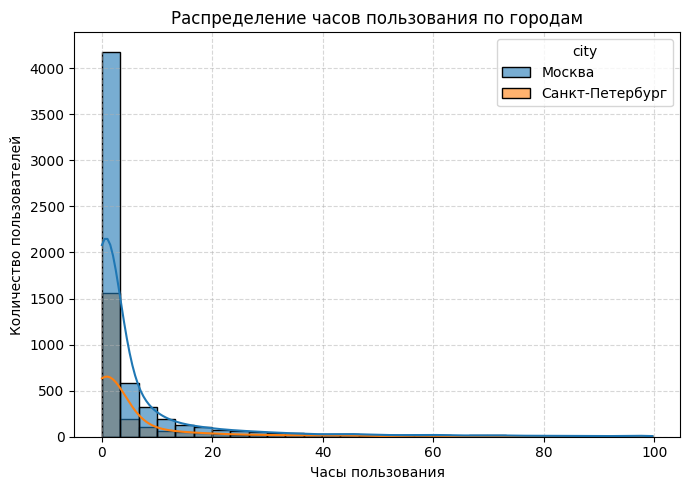

In [8]:

filtered_hours = df[df['hours'] <= 100]

plt.figure(figsize=(7, 5))
sns.histplot(
    data=filtered_hours,
    x='hours',
    hue='city',
    bins=30,
    alpha=0.6,
    kde=True,
    multiple='layer'
)

plt.xlabel('Часы пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение часов пользования по городам')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<b>Распределение часов в группах примерно одинаково</b>

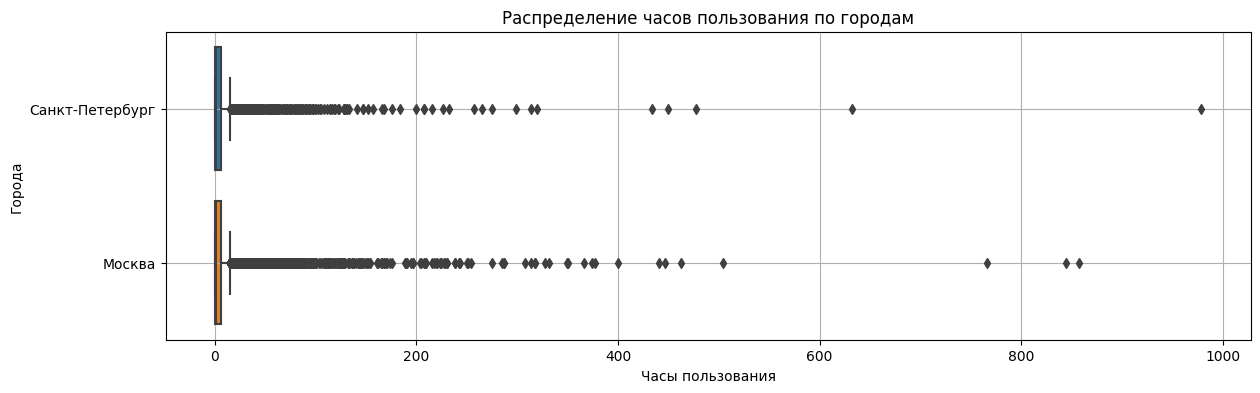

In [9]:
df_sort = df.groupby('city')['hours'].median().sort_values().index

plt.figure(figsize=(14, 4))
sns.boxplot(y='city', x='hours', data=df, order = df_sort, showfliers=True)  # Убедитесь, что выбросы отображаются
plt.title('Распределение часов пользования по городам')
plt.xlabel('Часы пользования')
plt.ylabel('Города')
plt.grid()
plt.show()

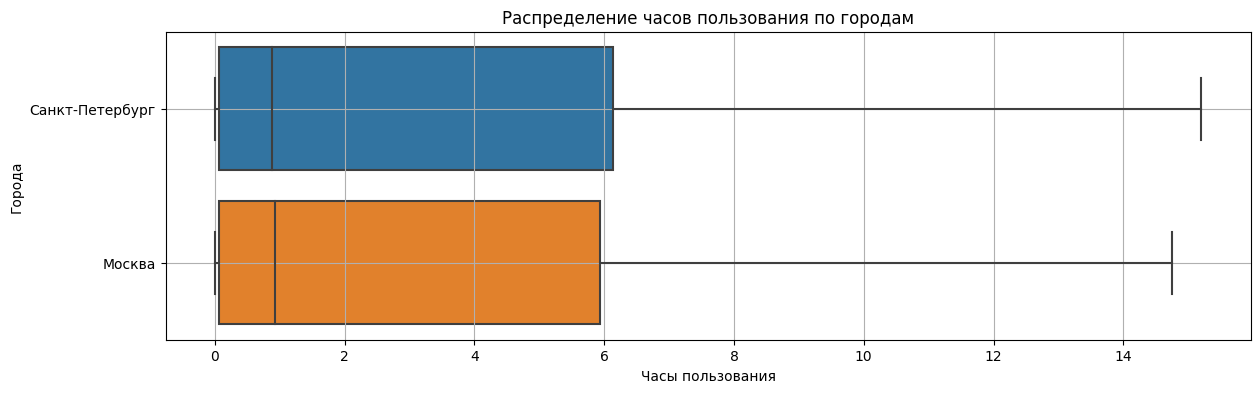

In [10]:
df_sort = df.groupby('city')['hours'].median().sort_values().index

plt.figure(figsize=(14, 4))
sns.boxplot(y='city', x='hours', data=df, order = df_sort, showfliers=False)  # Убедитесь, что выбросы отображаются
plt.title('Распределение часов пользования по городам')
plt.xlabel('Часы пользования')
plt.ylabel('Города')
plt.grid()
plt.show()

<b>Для проверки гипотезы  выберем односторонний двухвыборочный t-тест Стьюдента. Так как распределение часов в группах примерно одинаково, в обоих выборках есть выбросы они примерно эквивалентны и существенно не влияют на смещение среднего, выборки достаточно большие. Уровень статистической значимости установим стандартный 5%(0.05):</b>

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

- <b>Нулевая гипотеза Н0: А = В</b>
- <b>Альтернативная гипотеза Н1: А < B</b>

In [11]:
# Получаем массивы hours для каждого города
group_a = df[df['city'] == 'Москва']['hours']
group_b = df[df['city'] == 'Санкт-Петербург']['hours']

# Односторонний t-test
t_stat, p_value = st.ttest_ind(group_a, group_b, alternative='less', equal_var=False)


print(f"p-value: {p_value:.2f}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее в Санкт-Петербурге значительно больше.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: статистически значимых различий не найдено.")

p-value: 0.34
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий не найдено.


## 3. Аналитическая записка



- <b>Для проверки гипотезы был выбран односторонний двухвыборочный t-тест Стьюдента. Так как распределение часов в группах примерно одинаково, в обоих выборках есть выбросы они примерно эквивалентны и существенно не влияют на смещение среднего, выборки достаточно большие. Уровень статистической значимости выбран стандартный 5%(0.05).</b>

- <b>p-value: 0.22</b>

- <b>На основе имеющихся данных и результата проведённого теста не удалось подтвердить выдвигаемую гипотезу.</b>

- <b> У жителей этих городов схожий образ жизни и бытовые привычки. Люди в Санкт-Петербурге посвещают время чтению и прослушиванию аудио книг примерно столько же как и люди в Москве, столько сколько могут уделять этому время.</b>

----

# Часть 2. Анализ результатов A/B-тестирования

### Цель: Оценить корректность проведения A/B теста и проанализировать его результаты.

## 2. Загрузите данные, оцените их целостность.


In [13]:
display(participants.info())
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


None

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<b>Датафрэйм participants содержит 14525 строк и 4 столбца с идентификаторами пользователей, разделёнными группами А и В, названия теста, тип устройства.</b>

In [14]:
display(events.info())
events.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0


<b>Датафрэйм events содержит 787286 строк и 4 столбца с идентификаторами, датой события, именем события и деталями.По первичной оценке пропуски содержаться в столбце details, они не повлияют на анализ. </b>

### Проверим наличие пользователей учавствующих в разных тестах : 

In [15]:
# Группируем по тестам и выделяем уникальных пользователей для каждого теста
users_interface_eu = set(participants[participants['ab_test'] == 'interface_eu_test']['user_id'])
users_recommender = set(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])

# Ищем пересечение
cross_users = users_interface_eu & users_recommender

if len(cross_users) == 0:
    print('Пересечений нет — ни один пользователь не участвует сразу в двух тестах.')
else:
    print(f'Количество пользователей, участвующих одновременно в обоих тестах: {len(cross_users)}')
    print('user_id:', list(cross_users)[:10])  # Показываем первые найденные Id, если их немного


Количество пользователей, участвующих одновременно в обоих тестах: 887
user_id: ['C4D48357F1C18C76', '1D6A02B0987CD71A', '6A2064F288EF094F', '84F840D269A65875', '60D456E636F6C031', 'A944D2BCDFD50619', '9BFFAFDAB999DF19', '0082295A41A867B5', 'FEC0BCA6C323872F', '8BD80DB1522F7120']


In [16]:
# Группируем по user_id и считаем, в скольких тестах участвует каждый
user_test_counts = participants.groupby('user_id')['ab_test'].nunique()

# Находим пользователей, участвующих более чем в одном тесте
multi_test_users = user_test_counts[user_test_counts > 1].index

# Удаляем их из исходного DataFrame
participants_clean = participants[~participants['user_id'].isin(multi_test_users)].copy()

print(f'Удалено {len(multi_test_users)} пользователей, участвующих сразу в двух тестах.')



Удалено 887 пользователей, участвующих сразу в двух тестах.


In [17]:
# Группируем по тестам и выделяем уникальных пользователей для каждого теста
users_interface_eu = set(participants_clean[participants_clean['ab_test'] == 'interface_eu_test']['user_id'])
users_recommender = set(participants_clean[participants_clean['ab_test'] == 'recommender_system_test']['user_id'])

# Ищем пересечение
cross_users = users_interface_eu & users_recommender

if len(cross_users) == 0:
    print('Пересечений нет — ни один пользователь не участвует сразу в двух тестах.')
else:
    print(f'Количество пользователей, участвующих одновременно в обоих тестах: {len(cross_users)}')
   

Пересечений нет — ни один пользователь не участвует сразу в двух тестах.


In [18]:
# Считаем уникальных пользователей в каждом тесте
count_interface = participants_clean[participants_clean['ab_test'] == 'interface_eu_test']['user_id'].nunique()
count_recommender = participants_clean[participants_clean['ab_test'] == 'recommender_system_test']['user_id'].nunique()

print(f'Уникальных пользователей в тесте interface_eu_test: {count_interface}')
print(f'Уникальных пользователей в тесте recommender_system_test: {count_recommender}')

Уникальных пользователей в тесте interface_eu_test: 9963
Уникальных пользователей в тесте recommender_system_test: 2788


<b>Обнаружили 887 пользователей учавствующих одновременно в двух тестах. Удалили их для корректного проведения теста.</b>

### Проверим равномерность распределения пользователей по группам и по устройствам:

In [19]:
# Фильтрация по нужному тесту
df_test = participants_clean[participants_clean['ab_test'] == 'interface_eu_test']

# Подсчет уникальных пользователей в каждой группе
unique_users = df_test.groupby('group')['user_id'].nunique()

# Расчет процентной разницы между группами
percent_difference = ((unique_users['B'] - unique_users['A']) / unique_users['A']) * 100

print(f"Процентная разница в количестве пользователей между группами A и B: {percent_difference:.1f}%")


Процентная разница в количестве пользователей между группами A и B: 1.2%


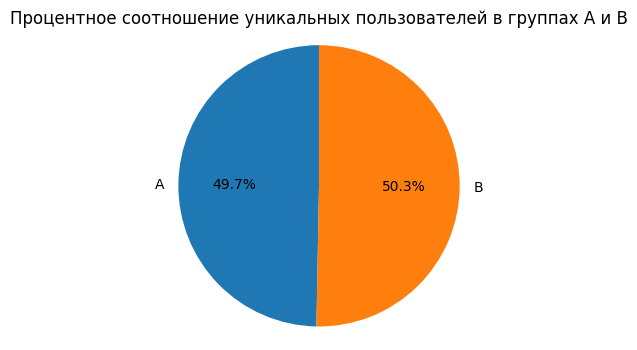

In [20]:
# Строим круговую диаграмму
plt.figure(figsize=(4, 4))
plt.pie(unique_users, labels=unique_users.index, autopct='%.1f%%', startangle=90)
plt.title('Процентное соотношение уникальных пользователей в группах A и B')
plt.axis('equal')  # Для равного соотношения сторон
plt.show()

<b>Процентная разница в количестве пользователей между группами A и B: 1.2% не существенна. Пользователи по группам распределены равномерно.</b>

In [21]:
# Получаем уникальные user_id для групп A и B
group_a_users = set(df_test[df_test['group'] == 'A']['user_id'])
group_b_users = set(df_test[df_test['group'] == 'B']['user_id'])

# Находим пересечение между группами A и B
common_users = group_a_users.intersection(group_b_users)

# Выводим количество и самих пользователей, если они есть
print(f"Количество пользователей, встречающихся одновременно в группах A и B: {len(common_users)}")
if common_users:
    print("Список пользователей, встречающихся в обеих группах:", common_users)
else:
    print("Пользователей, встречающихся в обеих группах, нет.")

Количество пользователей, встречающихся одновременно в группах A и B: 0
Пользователей, встречающихся в обеих группах, нет.


<b>Пересекающихся пользователей в группах А и В нет</b>

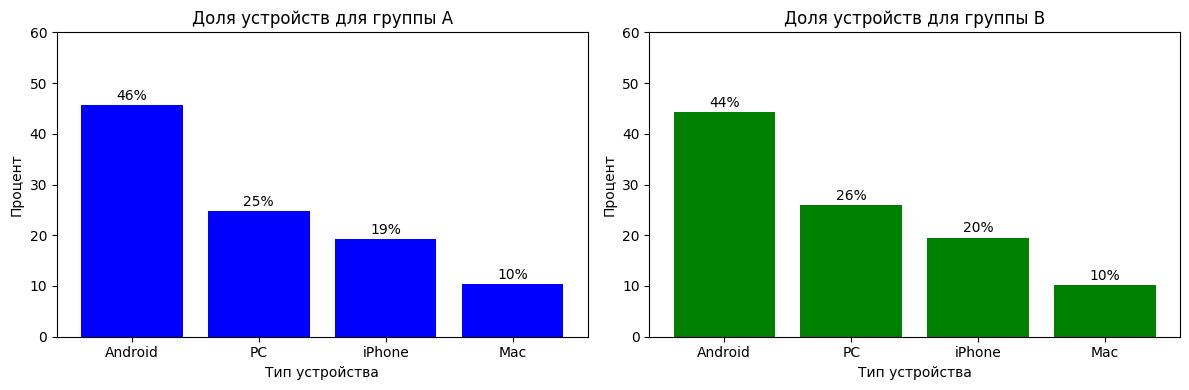

In [22]:
# Расчет доли каждого типа устройства для пользователей из группы A
device_distribution_a = df_test[df_test['group'] == 'A']['device'].value_counts(normalize=True) * 100

# Расчет доли каждого типа устройства для пользователей из группы B
device_distribution_b = df_test[df_test['group'] == 'B']['device'].value_counts(normalize=True) * 100

# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# График для группы A
axs[0].bar(device_distribution_a.index, device_distribution_a.values, color='blue')
axs[0].set_title('Доля устройств для группы A')
axs[0].set_ylabel('Процент')
axs[0].set_xlabel('Тип устройства')
axs[0].set_ylim(0, 60)

# Добавление подписей с процентами на столбцах группы A
for i, v in enumerate(device_distribution_a.values):
    axs[0].text(i, v + 1, f"{v:.0f}%", ha='center')

# График для группы B
axs[1].bar(device_distribution_b.index, device_distribution_b.values, color='green')
axs[1].set_title('Доля устройств для группы B')
axs[1].set_ylabel('Процент')
axs[1].set_xlabel('Тип устройства')
axs[1].set_ylim(0, 60)

# Добавление подписей с процентами на столбцах группы B
for i, v in enumerate(device_distribution_b.values):
    axs[1].text(i, v + 1, f"{v:.0f}%", ha='center')

plt.tight_layout()
plt.show()

<b>Распределение пользователей по устройствам в группах равномерно. Преобладающий  тип устройств Android 45% пользователей , PC 25%, iPhone 20, Mac 10%.</b>

<b>Объединим датафрэймы, выведем информацию и первые строки:</b>

In [23]:
df_merged = participants_clean.merge(events, on = 'user_id', how ='left')

In [24]:
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92758 entries, 0 to 92757
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     92758 non-null  object        
 1   group       92758 non-null  object        
 2   ab_test     92758 non-null  object        
 3   device      92758 non-null  object        
 4   event_dt    92758 non-null  datetime64[ns]
 5   event_name  92758 non-null  object        
 6   details     24628 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 5.7+ MB


,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN


<b>Оставим только те события, связанные с участвующими в изучаемом тесте пользователями</b>

In [25]:
# Получаем  user_id, которые участвуют в  тесте
test_users = df_merged.loc[df_merged['ab_test'] == 'interface_eu_test', 'user_id'].unique()

# Оставляем только события этих пользователей
df_filtered = df_merged[df_merged['user_id'].isin(test_users)]




<b>Оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации:</b>

In [26]:
# Определяем дату регистрации каждого пользователя
registration_df = df_filtered.groupby('user_id')['event_dt'].min().reset_index()
registration_df.rename(columns={'event_dt': 'registration_dt'}, inplace=True)

# Добавляем дату регистрации в основной датафрейм
df_lifetime = df_filtered.merge(registration_df, on='user_id', how='left')

# Считаем разницу в днях между событием и регистрацией
df_lifetime['lifetime_days'] = (df_lifetime['event_dt'] - df_lifetime['registration_dt']).dt.days

# Оставляем события только в первые 7 дней (включительно)
df_lifetime_7d = df_lifetime[df_lifetime['lifetime_days'] < 7]

print(f'Событий в течение первых 7 дней после регистрации: {df_lifetime_7d.shape[0]}')
df_lifetime_7d.sort_values(by=['user_id', 'event_dt'], ascending=True).head(2)


Событий в течение первых 7 дней после регистрации: 63805


,user_id,group,ab_test,device,event_dt,event_name,details,registration_dt,lifetime_days
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0


<b>Определим размер выборки для получения статистически значимых результатов A/B-теста</b>

In [28]:


# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый показатель конверсии
mde = 0.1 * p # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = abs(2 *  (np.arcsin(np.sqrt(p)) - np.arcsin(np.sqrt(p + mde)))),
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")




Необходимый размер выборки для каждой группы: 3761


<b>Выборки достаточны для получения статистически значимых результатов A/B-теста.</b>

In [29]:
#  Число уникальных пользователей, совершивших покупку, по группам:
purchase_events = df_lifetime_7d[df_lifetime_7d['event_name'] == 'purchase']
buyers_per_group = purchase_events.groupby('group')['user_id'].nunique().reset_index()
buyers_per_group.rename(columns={'user_id': 'buyers'}, inplace=True)

# Общее количество уникальных пользователей в каждой группе:
total_users_per_group = df_lifetime_7d.groupby('group')['user_id'].nunique().reset_index()
total_users_per_group.rename(columns={'user_id': 'total_users'}, inplace=True)

# Объединяем для удобства:
summary = buyers_per_group.merge(total_users_per_group, on='group')

# Считаем конверсию для каждой группы
summary['conversion'] = summary['buyers'] / summary['total_users']

# Считаем разницу между группами (для двух групп)
# (можно явно обозначить переменную для группы, если необходимо)
if len(summary) == 2:
    diff = summary.sort_values('group')['conversion'].diff().iloc[-1]
    display(f"Разница в конверсии между группами: {diff*100:.1f}%")

# вывод таблицы с конверсией
summary['conversion'] = (summary['conversion'] * 100).round(2)  # В процентах
summary.rename(columns={'conversion': 'conversion (%)'}, inplace=True)

(summary)


'Разница в конверсии между группами: 1.7%'

,group,buyers,total_users,conversion (%)
0,A,1377,4952,27.81
1,B,1480,5011,29.54


<b>Конверсия в теструемой группе В выше чем в контрольной А на 1.7%. Ожидаемый прирост 3п.п. не достигнут.</b>

## 4. Оценка результатов A/B-тестирования:

<h3>Гипотеза : Новая версия сайта повысит конверсию покупки.</h3>

- <b>Нулеваая гипотеза Н0: CR старой версии сайта равна(=) CR новой версии сайта</b>

- <b>Альтернативная гипотеза Н1: CR старой версии сайта меньше(<) CR новой версии сайта </b>

In [30]:


# Количество успехов (покупателей)
counts = summary.sort_values('group')['buyers'].values 

# Всего пользователей
nobs = summary.sort_values('group')['total_users'].values      

#  Применяем z-тест
stat, pval = proportions_ztest(count=counts, nobs=nobs, alternative='smaller')

print("\nРезультаты z-теста:")

print(f"p-value: {pval:.4f}")

# Интерпретация результата
alpha = 0.05
if pval < alpha:
    print("\nКонверсия в тестовой группе статистически значимо ВЫШЕ. Принимаем альтернативную гипотезу")
else:
    print("\nНет оснований отвергнуть H0: Разница в конверсии незначима.")


Результаты z-теста:
p-value: 0.0283

Конверсия в тестовой группе статистически значимо ВЫШЕ. Принимаем альтернативную гипотезу


### Выводы:

<b>На основании имеющихся данных и результата проведённого  A/B-теста можно сделать следующие выводы:</b>

- <b>Изменение интерфейса повлияло на рост ключевой метрики Конверсии в покупку . Показатель метрики в группе с новым интерфейсом выше на 1.7%</b>

- <b>p-value для оценки статистической значимости выявленного эффекта: 0.0283</b>

<h2>Исходя из полученного результата эксперимента стоит изменить интерфейс сайта!  <a class="tocSkip"> </h2>

